# Mass estimation

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import torchist
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
N = 100000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2)**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.1

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [4]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals, varnames = 'z')

    def forward(self, A, B):
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [6]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 1, precision = 64)

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [7]:
dl_train = samples[:2000].get_dataloader(batch_size = 512, shuffle = True)
dl_valid = samples[2000:4000].get_dataloader(batch_size = 512)

In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_10034687/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 52.2 K
1 | logratios2 | LogRatioEstimator_Ndim | 17.5 K
------------------------------------------------------
69.7 K    Trainable params
0         Non-trainable params
69.7 K    Total params
0.558     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  50%|█████     | 4/8 [00:00<00:00, 37.64it/s, loss=-0.0435, v_num=1e+7] 
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 43.26it/s, loss=-0.0435, v_num=1e+7, val_loss=0.00324]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 36.65it/s, loss=-0.0435, v_num=1e+7, val_loss=0.00324]


## Coverage tests

We first generate some prior samples.

In [10]:
samples_prior = swyft.Samples(z = np.random.rand(10000, 3)*2-1)

Then we can use the `test_coverage` method to estimate the probability mass contained in the smallest highest-likelihood regions that contain the true parameter.

In [11]:
coverage_samples = trainer.test_coverage(network, samples[-500:], samples_prior)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 190.79it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 197.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5000/5000 [00:59<00:00, 84.11it/s]


Based on these estimates, we can produce then the standard P-P plot. Here, $p$ corresponds to the probability mass *outside* the highest-likelihodo regions.  We here plot $1-p$, in order to move the credible regions with the highest credibility to the upper right corner.

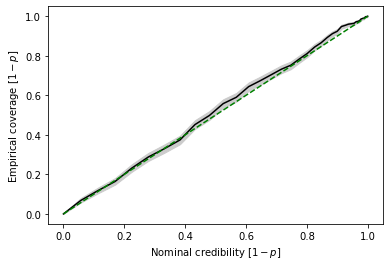

In [12]:
swyft.plot_pp(coverage_samples, "z[0]", "z[1]")

In P-P plots, regions with high credibility ($1-p = 68.3\%, 95.5\%, 99.7\%$ etc) become increasingly hard to interpret. Swyft also provides functionality to directly plot the corresponding $z_p$ values ($z_p = 1.0, 2.0, 3.0$ etc).

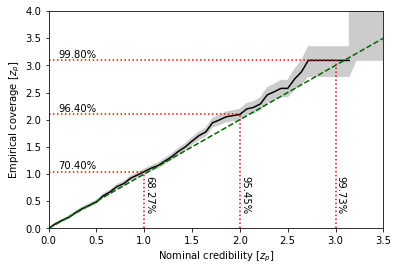

In [13]:
swyft.plot_zz(coverage_samples, "z[0]", "z[1]")